Dataset Preparation


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kaggle-cat-vs-dog-dataset


In [2]:
import os
import random
import shutil
from PIL import Image

def split_and_copy_images(src_dir, base_dst, class_name, split_ratio=(0.7, 0.15, 0.15), max_images=2400):
    class_dir = os.path.join(src_dir, class_name)
    files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    random.shuffle(files)

    num_total = min(len(files), max_images)
    num_train = int(split_ratio[0] * num_total)
    num_val = int(split_ratio[1] * num_total)
    num_test = num_total - num_train - num_val

    subsets = {
        'train': files[:num_train],
        'val': files[num_train:num_train+num_val],
        'test': files[num_train+num_val:num_total]
    }

    for subset, file_list in subsets.items():
        dst_dir = os.path.join(base_dst, subset, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        count = 0
        for fname in file_list:
            src_path = os.path.join(class_dir, fname)
            dst_path = os.path.join(dst_dir, fname)
            try:
                with Image.open(src_path) as img:
                    img.verify()
                shutil.copy(src_path, dst_path)
                count += 1
            except:
                continue
        print(f"Copied {count} images to {dst_dir}")

base_data_dir = "/content/small_dataset"
src_dir = os.path.join(path, "kagglecatsanddogs_3367a", "PetImages")

split_and_copy_images(src_dir, base_data_dir, "Cat")
split_and_copy_images(src_dir, base_data_dir, "Dog")



Copied 1679 images to /content/small_dataset/train/Cat
Copied 360 images to /content/small_dataset/val/Cat
Copied 360 images to /content/small_dataset/test/Cat
Copied 1680 images to /content/small_dataset/train/Dog
Copied 360 images to /content/small_dataset/val/Dog
Copied 360 images to /content/small_dataset/test/Dog


In [3]:
# Imports
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Paths and Parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 24
BASE_DIR = "/content/drive/MyDrive/DLProject/data"


Data Preprocessing

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Justification:
# - rescale: Normalizes pixel values to [0, 1] (helps faster convergence)
# - rotation/zoom/flip: Increases model robustness (augment small dataset)
# - validation_split: Reserve 20% data for validation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(base_data_dir, "train"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_data_dir, "val"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_data_dir, "test"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)



Found 3359 images belonging to 2 classes.
Found 720 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


Building the CNN Model

In [5]:
!pip install --upgrade scikeras scikit-learn

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

def build_resnet_model(learning_rate=1e-4, dropout_rate=0.5, dense_units=64):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



Training the Model

In [ ]:
import itertools
import numpy as np


param_grid = {
    'learning_rate': [1e-4, 1e-5],
    'dropout_rate': [0.3, 0.5],
    'dense_units': [64, 128]
}


best_accuracy = 0
best_model = None
best_params = {}
best_history = None

for params in itertools.product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    print(f"\nTraining with params: {config}")

    model = build_resnet_model(
        learning_rate=config['learning_rate'],
        dropout_rate=config['dropout_rate'],
        dense_units=config['dense_units']
    )

    history = model.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen,
        verbose=1
    )

    val_acc = history.history['val_accuracy'][-1]
    print(f"Validation accuracy: {val_acc:.4f}")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model = model
        best_params = config
        best_history = history

print("\nBest hyperparameters:")
print(best_params)
print(f"Best validation accuracy: {best_accuracy:.4f}")



Training with params: {'learning_rate': 0.0001, 'dropout_rate': 0.5, 'dense_units': 128}
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_179']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 345ms/step - accuracy: 0.4870 - loss: 0.7414 - val_accuracy: 0.5000 - val_loss: 0.7123
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.4899 - loss: 0.7060 - val_accuracy: 0.5014 - val_loss: 0.7161
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 262ms/step - accuracy: 0.5033 - loss: 0.6953 - val_accuracy: 0.5292 - val_loss: 0.6895
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 266ms/step - accuracy: 0.5283 - loss: 0.6909 - val_accuracy: 0.5250 - val_loss: 0.6864
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 274ms/step - accuracy: 0.5197 - loss: 0.6950 - val_accuracy: 0.5181 - val_loss: 0.6940
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.5155 - loss: 0.6908 - val_accuracy: 0.5292 - val_loss: 0.6878
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 272ms/step - accuracy: 0.5354 - loss: 0.6874 - val_accuracy: 0.5694 - val_loss: 0.6798
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 263ms/step - accuracy: 0.5450 - loss: 0.6907 - val

Accuracy/Loss Curves and Testing

In [11]:
# Predict class probabilities
y_true = test_gen.classes
y_pred_probs = best_model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_179']
Received: inputs=Tensor(shape=(32, 150, 150, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step


Classification Report:
              precision    recall  f1-score   support

         Cat       0.59      0.76      0.67       360
         Dog       0.67      0.48      0.56       360

    accuracy                           0.62       720
   macro avg       0.63      0.62      0.61       720
weighted avg       0.63      0.62      0.61       720



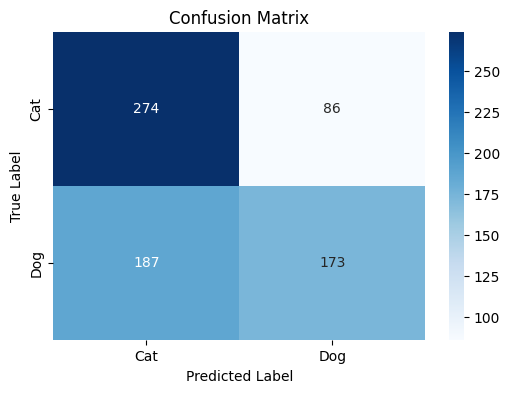

In [12]:
from sklearn.metrics import classification_report

# Print class names based on directory structure
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
loss, accuracy = best_model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.6208


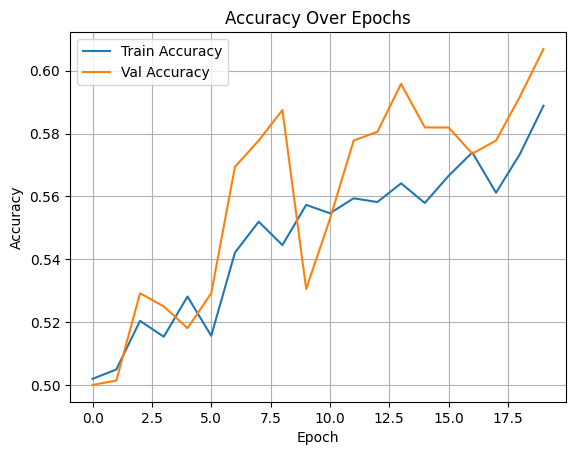

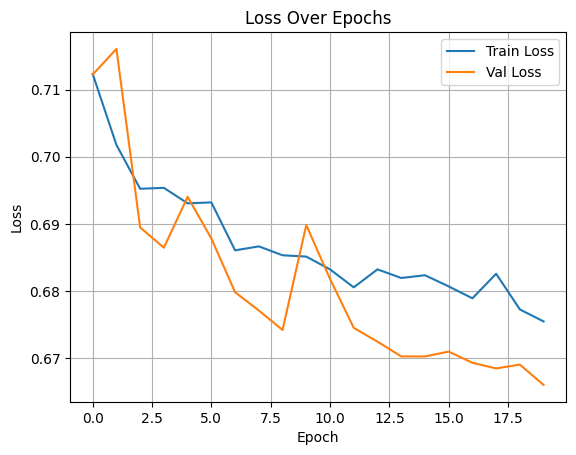

In [14]:
# Accuracy plot
plt.plot(best_history.history['accuracy'], label="Train Accuracy")
plt.plot(best_history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(best_history.history['loss'], label="Train Loss")
plt.plot(best_history.history['val_loss'], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Performance Metrics and Confusion Matrix

In [ ]:
# # Predictions
# y_true = val_gen.classes
# y_pred = (model.predict(val_gen) > 0.5).astype("int32").flatten()

# # Metrics
# print("\nClassification Report:\n")
# print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

# # Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(6, 5))
# plt.imshow(cm, cmap='Blues')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.colorbar()
# plt.xticks([0, 1], ["Cat", "Dog"])
# plt.yticks([0, 1], ["Cat", "Dog"])
# plt.show()
